In [1]:
import pandas as pd
import numpy as np
np.random.seed(3)
np.set_printoptions(suppress=True)
import matchms as mms
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
random.seed(3)
import h5py
import dreams.utils.spectra as su
from tqdm.auto import tqdm
tqdm.pandas()
from itertools import combinations
from dreams.definitions import MASSIVE_DATA
from dreams.utils.io import setup_logger
from dreams.algorithms.lsh.lsh import BatchedPeakListRandomProjection
from dreams.utils.dformats import DataFormatA
from dreams.utils.plots import init_plotting
init_plotting()
%load_ext autoreload
%autoreload 2

In [4]:
logger = setup_logger()

In [5]:
# with h5py.File('/storage/plzen1/home/romanb/msvn_A/msvn_A.hdf5', 'r') as f:
#     spectra = f['spectra']
#     print(spectra.shape)
#     idx = sorted(random.sample(range(spectra.shape[0]), 200_000))
#     spectra = spectra[idx, :, :]
#     print(spectra.shape)
#     prec_mzs = f['precursor mz'][idx]
#     print(prec_mzs.shape)
#     with h5py.File('/storage/plzen1/home/romanb/msvn_A/msvn_A_rand100k.hdf5', 'w') as f:
#         f.create_dataset(name='spectra', data=spectra)
#         f.create_dataset(name='precursor mz', data=prec_mzs)
# spectra.shape, prec_mzs.shape

In [6]:
with h5py.File(MASSIVE_DATA / 'msvn' / 'msvn_A_rand200k.hdf5', 'r') as f:
    spectra = f['spectra'][2000:3000]
    prec_mzs = f['precursor mz'][2000:3000]

In [31]:
df = []
for n_hyperplanes in tqdm([25, 1000]):
    for bin_step in [0.5]:
        # lsh = PeakListRandomProjection(bin_step=bin_step, max_mz=1000., n_hyperplanes=n_hyperplanes)
        lsh = BatchedPeakListRandomProjection(
            subbatch_size=5_000, max_mz=DataFormatA().max_mz, bin_step=bin_step, n_hyperplanes=n_hyperplanes
        )
        lshs = lsh.compute(np.transpose(spectra, (0, 2, 1)), logger=logger)
        # mona['LSH'] = mona['PARSED PEAKS'].apply(lambda pl: lsh.compute(pl))
        df.append({
            'Num. hyperplanes': n_hyperplanes,
            'Bin size': bin_step,
            'Unique LSH [%]': len(np.unique(lshs)) / len(lshs) * 100
        })
df = pd.DataFrame(df)

  0%|          | 0/2 [00:00<?, ?it/s]

In [32]:
df_clashes = pd.DataFrame({'i': range(lshs.shape[0]), 'LSH': lshs}).groupby('LSH').agg({'LSH': list, 'i': list})
df_clashes['n_clashes'] = df_clashes['LSH'].apply(len)
df_clashes.sort_values(by='n_clashes', ascending=False)

,LSH,i,n_clashes
LSH,,,
8864742322257525109,"[8864742322257525109, 8864742322257525109, 886...","[270, 410, 830, 832]",4
2674475802999457154,"[2674475802999457154, 2674475802999457154, 267...","[329, 333, 379]",3
-4745672232281994148,"[-4745672232281994148, -4745672232281994148]","[55, 434]",2
-3745598565435660601,"[-3745598565435660601, -3745598565435660601]","[250, 253]",2
5620053725717761374,"[5620053725717761374, 5620053725717761374]","[112, 529]",2
...,...,...,...
-3983045723897757102,[-3983045723897757102],[986],1
-3964999794958866562,[-3964999794958866562],[59],1
-3962709873715472766,[-3962709873715472766],[808],1


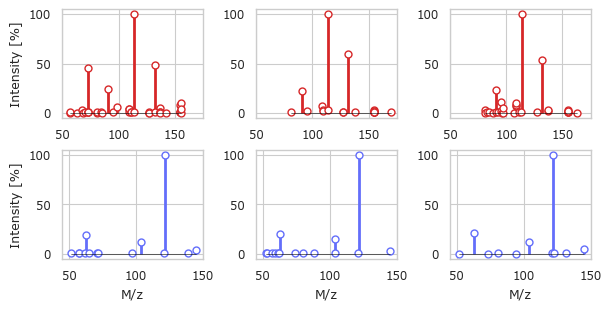

In [51]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
init_plotting()
fig = plt.figure(layout='constrained')
fig.set_size_inches(6, 3)
gs = gridspec.GridSpec(2, 3, figure=fig)

from dreams.utils.plots import get_plotly_palette
from dreams.definitions import FIGURES
palette = get_plotly_palette(as_hex=True)

for plot_i, i in enumerate([245, 522, 759]):
    ax = fig.add_subplot(gs[0, plot_i])
    su.plot_peak_list(su.unpad_peak_list(spectra[i].T).T, xlim=(50, 175), figsize=(2, 2), ax=ax, ylabel=plot_i==0, xlabel=False, color=palette[2])
for plot_i, i in enumerate([329, 333, 379]):
    ax = fig.add_subplot(gs[1, plot_i])
    su.plot_peak_list(su.unpad_peak_list(spectra[i].T).T, xlim=(45, 150), figsize=(2, 2), ax=ax, ylabel=plot_i==0, color=palette[0])
plt.savefig(FIGURES / 'lsh_examples.pdf')
plt.show()

In [ ]:
df = []
for n_hyperplanes in tqdm([90, 60, 40, 30, 20, 10]):
    for bin_step in [0.05, 0.5, 1]:
        # lsh = PeakListRandomProjection(bin_step=bin_step, max_mz=1000., n_hyperplanes=n_hyperplanes)
        lsh = BatchedPeakListRandomProjection(
            subbatch_size=5_000, max_mz=DataFormatA().max_mz, bin_step=bin_step, n_hyperplanes=n_hyperplanes
        )
        lshs = lsh.compute(np.transpose(spectra, (0, 2, 1)), logger=logger)
        # mona['LSH'] = mona['PARSED PEAKS'].apply(lambda pl: lsh.compute(pl))
        df.append({
            'Num. hyperplanes': n_hyperplanes,
            'Bin size': bin_step,
            'Unique LSH [%]': len(np.unique(lshs)) / len(lshs) * 100
        })
df = pd.DataFrame(df)

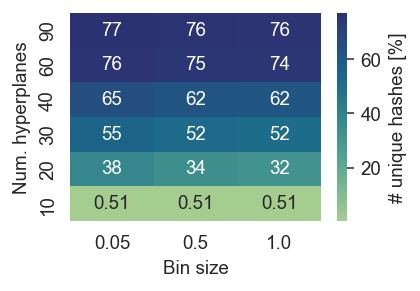

In [8]:
fig, ax=plt.subplots(1, 1, dpi=135, figsize=(3, 2))
sns.heatmap(df.pivot_table(values='Unique LSH [%]', columns='Bin size', index='Num. hyperplanes'), annot=True, cbar_kws={'label': '# unique hashes [%]'}, cmap='crest')
ax.invert_yaxis()
plt.savefig('lsh_msvn_A_200k_heatmap.pdf', bbox_inches='tight')
plt.show()

In [4]:
cos_dist = mms.similarity.CosineGreedy(tolerance=0.5)

Analyze two variants: 20 and 60 hyperplanes.

In [35]:
dfs = {}

for n_hyperplanes in [20, 60]:

    lsh = BatchedPeakListRandomProjection(
        subbatch_size=10_000, max_mz=DataFormatA().max_mz, bin_step=1, n_hyperplanes=n_hyperplanes
    )
    lshs = lsh.compute(np.transpose(spectra, (0, 2, 1)), logger=logger)
    print(len(np.unique(lshs)), len(np.unique(lshs)) / len(lshs))

    df = pd.DataFrame({
        'PARSED PEAKS': [su.unpad_peak_list(pl.T) for pl in spectra],
        'PRECURSOR M/Z': prec_mzs,
        'LSH': lshs
    })
    df['MMS Spectrum'] = df.progress_apply(
        lambda row: mms.Spectrum(
            mz=row['PARSED PEAKS'][0],
            intensities=row['PARSED PEAKS'][1],
            metadata={'precursor_mz': row['PRECURSOR M/Z']}
    ), axis=1)

    dfs[n_hyperplanes] = df

2023-03-16 14:52:30,291 | INFO | Computing LSH for batch [0:10000] (out of 200000)...
2023-03-16 14:52:31,399 | INFO | Computing LSH for batch [10000:20000] (out of 200000)...
2023-03-16 14:52:32,372 | INFO | Computing LSH for batch [20000:30000] (out of 200000)...
2023-03-16 14:52:33,395 | INFO | Computing LSH for batch [30000:40000] (out of 200000)...
2023-03-16 14:52:34,414 | INFO | Computing LSH for batch [40000:50000] (out of 200000)...
2023-03-16 14:52:35,491 | INFO | Computing LSH for batch [50000:60000] (out of 200000)...
2023-03-16 14:52:36,474 | INFO | Computing LSH for batch [60000:70000] (out of 200000)...
2023-03-16 14:52:37,445 | INFO | Computing LSH for batch [70000:80000] (out of 200000)...
2023-03-16 14:52:38,430 | INFO | Computing LSH for batch [80000:90000] (out of 200000)...
2023-03-16 14:52:39,442 | INFO | Computing LSH for batch [90000:100000] (out of 200000)...
2023-03-16 14:52:40,448 | INFO | Computing LSH for batch [100000:110000] (out of 200000)...
2023-03-16 

  0%|          | 0/200000 [00:00<?, ?it/s]

2023-03-16 14:52:57,125 | INFO | Computing LSH for batch [0:10000] (out of 200000)...
2023-03-16 14:52:58,363 | INFO | Computing LSH for batch [10000:20000] (out of 200000)...
2023-03-16 14:52:59,636 | INFO | Computing LSH for batch [20000:30000] (out of 200000)...
2023-03-16 14:53:00,829 | INFO | Computing LSH for batch [30000:40000] (out of 200000)...
2023-03-16 14:53:02,032 | INFO | Computing LSH for batch [40000:50000] (out of 200000)...
2023-03-16 14:53:03,240 | INFO | Computing LSH for batch [50000:60000] (out of 200000)...
2023-03-16 14:53:04,587 | INFO | Computing LSH for batch [60000:70000] (out of 200000)...
2023-03-16 14:53:05,870 | INFO | Computing LSH for batch [70000:80000] (out of 200000)...
2023-03-16 14:53:07,061 | INFO | Computing LSH for batch [80000:90000] (out of 200000)...
2023-03-16 14:53:08,253 | INFO | Computing LSH for batch [90000:100000] (out of 200000)...
2023-03-16 14:53:09,516 | INFO | Computing LSH for batch [100000:110000] (out of 200000)...
2023-03-16 

  0%|          | 0/200000 [00:00<?, ?it/s]

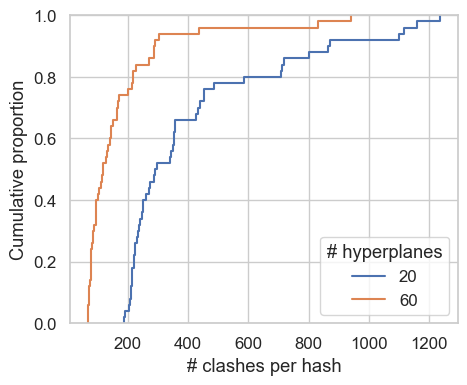

In [36]:
for h, df in dfs.items():
    sns.ecdfplot(df['LSH'].value_counts()[:50], label=h)
plt.xlabel('# clashes per hash')
plt.ylabel('Cumulative proportion')
plt.savefig('lshs_clashes_cum.pdf')
plt.legend(title='# hyperplanes')

Intra hash cosine distances.

In [37]:
clashes = {}
for h, df in dfs.items():
    max_pairs = 10
    cos_scores_clashes = []
    lsh_counts = df['LSH'].value_counts()
    for lsh_clash_val in tqdm(lsh_counts[lsh_counts > 1].index):
        clash_idx = df[df['LSH'] == lsh_clash_val]
        if len(clash_idx) > max_pairs:
            clash_idx = clash_idx.sample(n=max_pairs)
        spec_pairs = combinations(clash_idx['MMS Spectrum'], 2)
        cos_scores_clashes.extend([float(cos_dist.pair(sp[0], sp[1])['score']) for sp in spec_pairs])
    clashes[h] = cos_scores_clashes
    print(len(cos_scores_clashes))

  0%|          | 0/21959 [00:00<?, ?it/s]

230418


  0%|          | 0/14953 [00:00<?, ?it/s]

98183


Inter hash cosine distances.

In [38]:
different = {}
for h, cos_scores_clashes in clashes.items():
    cos_scores_different = []
    for _ in tqdm(range(len(cos_scores_clashes))):
        i1 = random.randrange(0, len(df))
        i2 = random.randrange(0, len(df))
        while df['LSH'][i1] == df['LSH'][i2]:
            i2 = random.randrange(0, len(df))
        cos_scores_different.append(float(cos_dist.pair(
            df['MMS Spectrum'][i1],
            df['MMS Spectrum'][i2]
        )['score']))
    different[h] = cos_scores_different

  0%|          | 0/230418 [00:00<?, ?it/s]

  0%|          | 0/98183 [00:00<?, ?it/s]

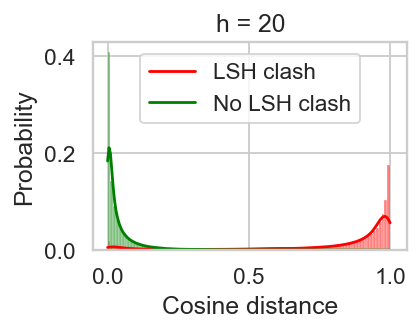

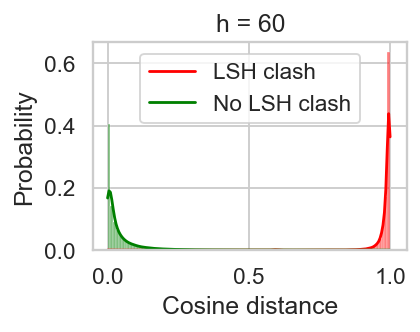

In [63]:
for h in dfs.keys():
    fig, ax=plt.subplots(1, 1, dpi=135, figsize=(3, 2))
    sns.histplot(clashes[h], legend='LSH clash', fill=True, color='red', binwidth=0.01, stat='probability', kde=True)
    sns.histplot(different[h], fill=True, color='green', binwidth=0.01, stat='probability', kde=True)
    # sns.histplot([e[2] for e in cos_scores_cl_closest], legend='closets', fill=True, color='blue', binwidth=0.01, stat='probability', kde=True)
    plt.legend(['LSH clash', 'No LSH clash'], loc='upper center')
    ax.set_xlabel('Cosine distance')
    # ax.set_yscale('log')
    plt.title(f'h = {h}')
    # plt.savefig('lsh_mona.pdf', bbox_inches='tight')
    plt.show()

Find closest intra hash cosine distances.

In [50]:
closest = {}
idx = df.sample(n=300).index
for h, df in dfs.items():
    cos_scores_cl_closest = []
    for i in tqdm(idx):
        spec_i = df['MMS Spectrum'][i]
        diff_idx = df[df['LSH'] != df['LSH'][i]].copy()
        diff_idx['Cos to spec i'] = diff_idx['MMS Spectrum'].apply(
            lambda spec: float(cos_dist.pair(spec, spec_i)['score'])
        )
        j = diff_idx['Cos to spec i'].idxmax()
        print(diff_idx['Cos to spec i'][j], i, j, df['LSH'][i], df['LSH'][j])
        cos_scores_cl_closest.append((i, j, diff_idx['Cos to spec i'][j]))
    closest[h] = cos_scores_cl_closest

  0%|          | 0/300 [00:00<?, ?it/s]

0.9289640260640868 1168 19946 36150 36148
0.9843467391929571 53697 110757 696861 698901
0.8756510999404988 51465 121430 278706 344762
0.99821779769419 87018 183357 245476 261860
0.9972151893082986 94789 93605 888212 896404
0.9938411964856602 65548 139655 372503 364055
0.981549027824015 66438 66439 888381 822845
0.9369414329420952 271 15149 492470 476086
0.9973687522299294 87351 117211 140528 142576
0.9778612601539522 114444 137290 496673 364577
0.9857682363671737 165045 127031 751577 747481
0.8861166038703288 122357 122810 950710 950460
0.9917285936410727 199542 43604 991543 991607
0.9999065329709275 41662 143865 376468 310420
0.9932155974552261 127314 54711 832497 832505
0.9863702051234733 140828 147273 247188 255380
0.9920331446372386 49717 40427 855462 855430
0.9822167052647574 275 52310 341530 79387
0.9919446127235808 41078 158433 68959 69471
0.8409206487453268 67423 116676 239842 239840
0.9303308789469878 40387 106331 253715 236819
0.992134451750534 53488 8451 524080 524084
0.8257

  0%|          | 0/300 [00:00<?, ?it/s]

0.9289640260640868 1168 19946 39748013751444912 39745948006393328
0.9843467391929571 53697 110757 766207155141666016 768450154567361760
0.8756510999404988 51465 121430 306441378209788845 379070167464728485
0.99821779769419 87018 183357 269904802362071882 287919200869456714
0.9972151893082986 94789 93605 976600364534543422 985607563789284414
0.9938411964856602 65548 139655 409572062761636936 400283386400003144
0.9875332571594267 66438 181770 976786310634306617 976786173186964537
0.9369414329420952 271 15149 541476618568710335 523462202862414079
0.9973687522299294 87351 117211 154512378990604243 156764178804289491
0.9778612601539522 114444 137290 546098726354445346 400857342023197736
0.9884114365762381 165045 118314 826368667520683523 826368667520699395
0.8861166038703288 122357 122810 1045317115143454313 1045042254919522925
0.9939521401552767 199542 126799 1090213327445406078 1090213327437017470
0.9999065329709275 41662 143865 413932017591125762 341311198738646786
0.9932155974552261 127

<AxesSubplot: ylabel='Count'>

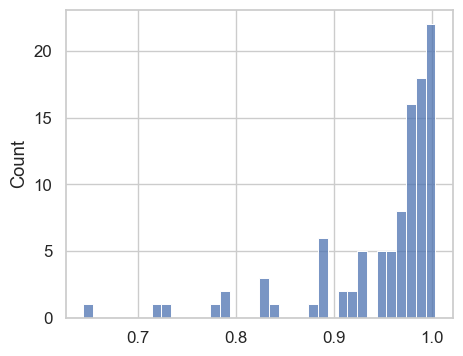

In [48]:
sns.histplot([c[2] for c in closest[20]], binwidth=0.01)

<AxesSubplot: ylabel='Count'>

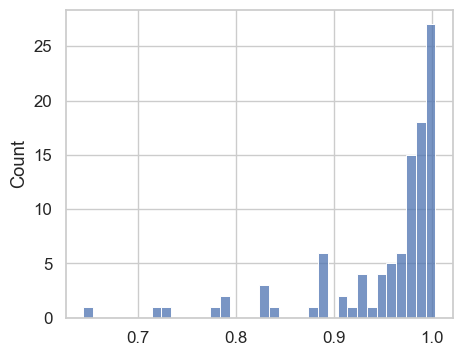

In [49]:
sns.histplot([c[2] for c in closest[60]], binwidth=0.01)

In [62]:
from numpy import mean, absolute
def mean_mad(a):
    a = np.array(a)
    m = mean(a)
    return m, mean(absolute(a - m))

for h in dfs.keys():
    for name, s in [('clashes', clashes[h]), ('different', different[h]), ('closest', [c[2] for c in closest[h]])]:
        m, mad = mean_mad(s)
        print(f'{name} {h}: {m:.3f} ± {mad:.3f}')

clashes 20: 0.812 ± 0.202
different 20: 0.050 ± 0.056
closest 20: 0.956 ± 0.046
clashes 60: 0.982 ± 0.019
different 60: 0.050 ± 0.055
closest 60: 0.960 ± 0.043


Often spectra similar by cosine distance share high peak but differ in noise. It can be beneficial for the pre-training, so the goal of LSH should be only to remove duplicates or nearly duplicates.

0.9988947044215256
[[113.96357727  72.93731689 131.97410583  90.94762421  71.95210266
  108.95816803 154.99009705 156.04191589 114.9654541  132.97485352]
 [  1.           0.63362515   0.42396951   0.20862103   0.04981573
    0.03252618   0.0234778    0.01478619   0.01267941   0.00892288]]
[504917]


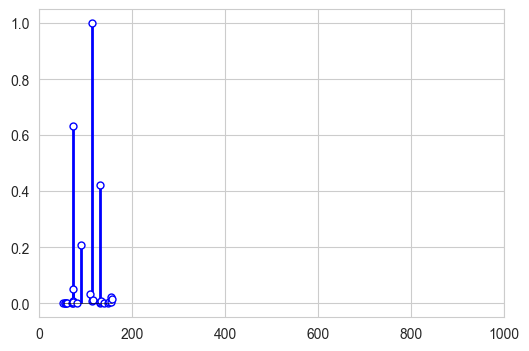

[[113.96360779  72.93734741 131.97415161  90.94763947 154.99057007
  108.95805359 148.97694397  71.92964172 126.06638336 114.96550751]
 [  1.           0.60484493   0.40201035   0.1971608    0.02892492
    0.02789966   0.02106957   0.01401984   0.01303352   0.00904361]]
[504916]


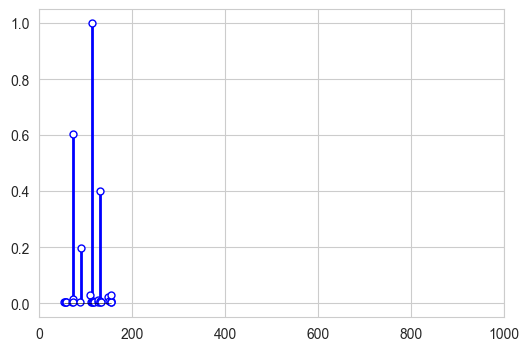

In [100]:
# i, j = 118930, 174524
# i, j = 122200, 176658
i, j = 33823, 107970
print(float(cos_dist.pair(df['MMS Spectrum'][i], df['MMS Spectrum'][j])['score']))
for k in [i, j]:
    # print(mona['PARSED PEAKS'][k])
    print(su.get_highest_peaks(df['PARSED PEAKS'][k], 10).T)
    print(lsh.compute(np.expand_dims(df['PARSED PEAKS'][k], axis=0)))
    su.plot_peak_list(df['PARSED PEAKS'][k].T, plotly=False, xlim=(0, 1000))

In [222]:
# lsh = PeakListRandomProjection(bin_step=0.5, max_mz=1000.)
# lsh_i = lsh.compute(mona['PARSED PEAKS'][i], as_int=False)
# lsh_j = lsh.compute(mona['PARSED PEAKS'][j], as_int=False)
# (lsh_i != lsh_j).sum()

2